<font color='blue'>Cell 1
Importing libraries

In [22]:
import numpy as np
import pandas as pd

# Reading and verifying data

<font color='blue'>Cell 2
Reading in the data set

In [23]:
data = pd.read_csv('/content/converted_data.csv')
used_data = data.copy()
used_data = used_data.iloc[:,1:]
used_data.head()

,Protein,AA Sequence,SST3 Sequence,Length,B Count,C Count,H Count,numB,numC,numH
0,>VACUOLAR MORPHOGENESIS PROTEIN VAM7; SWP:P329...,KMSEKLRIKVDDVKINPKYVLYGVSTPNKRLYKRYSEFWKLKTRLE...,CCCCCBBBBBCBBBBCCCCBBBBBBBBCBBBBBBHHHHHHHHHHHH...,117,0.196581,0.452991,0.350427,23,53,41
1,>IRON(III) DICITRATE TRANSPORT PROTEIN FECA; S...,NDVFEHAGARDVIRREDFAKTGATTREVLNRIPGVSAPENNGTGSH...,CCCCCCCBBBBBBCHHHHHHCCCCCCHHHHCCCCBBBCCCCCCCCC...,633,0.633491,0.333333,0.033175,401,211,21
2,>DIPETALIN; SWP:O96790; PDB:1KMAA,FQGNPCECPRALHRVCGSDGNTYSNPCMLTCAKHEGNPDLVQVHEG...,CCCCCCCCCCCCBBBBBCCCBBBBCHHHHHHHHHHCCCCCCCCCCC...,55,0.163636,0.654545,0.181818,9,36,10
3,>CHEMOTAXIS PROTEIN CHEY; SWP:P07366; PDB:1KMIZ,SIKPADEHSAGDIIARIGSLTRMLRDSLRELGLDQAIAEAAEAIPD...,CCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHCCHHHH...,177,0.000000,0.175141,0.824859,0,31,146
4,>CHEMOTAXIS PROTEIN CHEY; SWP:P06143; PDB:1KMIY,ADKELKFLVVDDFSTMRRIVRNLLKELGFNNVEEAEDGVDALNKLQ...,CCCCBBBBBBBCCCHHHHHHHHHHHHHCCCBBBBBCCHHHHHHHHH...,128,0.257812,0.304688,0.437500,33,39,56


<font color='blue'>Cell 3
Removing proteins with non standard amino acids

In [24]:
#Check the dataset to make sure only proteins with standard
#amino accids are included in the set
def remove_non_standard_aa():
  num_nonstd = 0
  aa_nonstd = []
  num_prot = len(used_data)
  for prot in range(num_prot):
    if used_data.iloc[prot,1].find('X') != -1:
      num_nonstd += 1
      aa_nonstd.append(prot)
    elif used_data.iloc[prot,1].find(';') != -1:
      num_nonstd += 1
      aa_nonstd.append(prot)
  return aa_nonstd

aa_nonstd = remove_non_standard_aa()
used_data = used_data.drop(used_data.index[aa_nonstd])

<font color='blue'>Cell 4
Data set verification

In [25]:
#Check the dataset to make sure no data is missing and Check the class labels
#need to define “verify_dataset” function
def verify_dataset(data):
  #Use data_found as a dummy variable to determine if to print missing value information
  data_found = 1
  for each_column in data.columns:
    if data[each_column].isnull().any():
            print("Data missing in Column " + each_column)
            #if any rows are not missing return Dataset is complete. No missing value
            quit()
    if data_found == 1:
        print("Dataset is complete. No missing values")
    return

#Call verify_dataset and check data
verify_dataset(used_data)

Dataset is complete. No missing values


# Data encoding

<font color='blue'>Cell 5
Data set splitting function

In [26]:
#Splitting The Data Set into training and testing
#The "sample" function will sort the data rows (proteins) randomly
def split_dataset_test_train(data,limit,train_size):
  data = data.sample(frac=limit).reset_index(drop=True)
  training_data = data.iloc[:int(train_size * len(data))].reset_index(drop=True)
  ##Determine the integer location (iloc) from beginning of array (:) to the train_size and do a ”cleanup” with a reset call
  testing_data = data.iloc[int(train_size * len(data)):].reset_index(drop=True)
  ##Determine the integer location (iloc) from train_size to end of array (: ) and do a ”cleanup” with a reset call
  return training_data, testing_data

# Note: the function is called upon later, in Cell 14.


<font color='blue'>Cell 6
Creating the amino acid encoding alphabet

In [27]:
#Defining codes for the alphabet
aa_codes = np.array(['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T',
            'V','W','Y','Null'])
#An identity matrix is one such that all diagonal elements are equal to 1, while the rest are 0
#Each column is assigned to an amino acid
aa_alphabet = pd.DataFrame(data=np.identity(21), columns=aa_codes)


<font color='blue'>Cell 7
Creating the secondary structure encoding alphabet

In [28]:
#Defining the encoding matrix for the structures
sst3_codes = np.array(['B','C','H'])
sst3_alphabet = pd.DataFrame(data=np.identity(3), columns=sst3_codes)

<font color='blue'>Cell 8
Amino acid encoding and windowing function

In [29]:
def aa_encode(data_set):
  #The array that will contain the encoded sequences is first
  #initialized with window_size*21 columns rows of encoded data will then be added
    aa_encoded = np.empty((0,(window_size*21)))
    #The null padding length is calculated from the window size
    null_size = int(window_size/2)
    null_pad = [aa_alphabet['Null']]*null_size
    null_pad = np.array(null_pad)

    #This function iterates over all proteins in the data set provided
    for i in range(len(data_set)):
        #For each amino acid in a sequence, retrieve the “bitized” sequence from #aa_alphabet.
        #A list is created containing the bit sequences for amino acids in the current protein
        to_encode = [aa_alphabet[aa] for aa in data_set.iloc[i,1]]
        to_encode = np.array(to_encode)

        #After retrieving the bit sequences of all amino acids in a given sequence, we attach the null sequence using np.concatenate()
        #Using axis=0 attaches the null padding in-line with the encoded sequence. Using axis=1 would place the padding in a separate row #below the encoded sequence

        #The encoded sequence is then padded with the "Null" sequence
        to_encode = np.concatenate((null_pad,to_encode), axis=0)
        to_encode = np.concatenate((to_encode,null_pad), axis=0)

        #The encoded sequences representing the amino acids are gathered in groups according to the window size
        X_data = [to_encode[top:top+window_size,:].flatten() for top in range(len(data_set.iloc[i,1]))]
        X_data = np.array(X_data)

        #The current protein's data is added to the array of all encoded proteins
        aa_encoded = np.concatenate((X_data,aa_encoded),axis=0)
    return aa_encoded


<font color='blue'>Cell 9
Secondary structure encoding function

In [30]:
def sst3_encode(data_set):
    sst3_encoded = np.empty((0,3))
    for i in range(len(data_set)):
        to_encode = [sst3_alphabet[sst3] for sst3 in data_set.iloc[i,2]]
        to_encode = np.array(to_encode)
        sst3_encoded = np.concatenate((to_encode,sst3_encoded),axis=0)
    return sst3_encoded



# Creating and training the model

<font color='blue'>Cell 10
Activation function definitions

In [31]:
#sigmoid and its derivative
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

def user_softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

<font color='blue'>Cell 11
Training function definition

In [32]:
def training(lr, batch_size, epochs):

  hidden_size = 5
  #random.random returns number from 0 to 1 while random.randn
  #returns Gaussian random number from -1 to 1, with mean of 0

  #Weight initialization
  w0 = 2*np.random.random((window_size*21, hidden_size)) - 1
  w1 = 2*np.random.random((hidden_size, 3)) - 1

  bh = np.random.randn(hidden_size)
  bo = np.random.randn(3)

  #Recall that % returns remainder (modulus)
  #Recall that // returns largest divisor
  rem = len(X_train) % batch_size
  num_batch = len(X_train)//batch_size
  if rem != 0:
    num_batch += 1

  #Errors - for graph later
  errors = []

  for epoch in range(epochs):
############# feedforward
    for curr_batch in range(num_batch):
        # Phase 1
        # Finding the current batch
        batch_start = curr_batch * batch_size
        batch_end = batch_start + batch_size
        input_batch = X_train[batch_start:batch_end]
        #First layer propagation. This equation calculates dot product of input layer
        #vector (batchsize x (window_size*21)) with weight matrix w0 ((window_size*21)xhiddenlayer size)
        zh = np.dot(input_batch, w0) + bh
        layer1 = sigmoid(zh)

        # Phase 2: This equation calculates dot #product of the first layer and weight
        zo = np.dot(layer1, w1) + bo
        layer2 = user_softmax(zo)

    ########## Back Propagation

    ########## Phase 1
        labels_batch = y_train[batch_start:batch_end]
        layer2_error = layer2 - labels_batch
        layer2w_delta = np.dot(layer1.T, layer2_error)

        layer2b_delta = layer2_error

    ########## Phases 2
        #propogation of error to layer1
        dcost_dah = np.dot(layer2_error , w1.T)
        dah_dzh = sigmoid_deriv(zh)

        layer1_error = dah_dzh * dcost_dah
        layer1w_delta = np.dot(input_batch.T, layer1_error)

        layer1b_delta = layer1_error


        # Update Weights with learning rate n

        w0 -= lr * layer1w_delta
        w1 -= lr * layer2w_delta

        #Update biases with learning rate n
        bh -= lr * layer1b_delta.sum(axis=0)
        bo -= lr * layer2b_delta.sum(axis=0)

    error = np.mean(np.abs(layer2_error))
    errors.append(error)

  return [w0,bh,w1,bo], error, errors

# Evaluation and Sequence Prediction

<font color='blue'>Cell 12
Evaluation function definition

In [33]:
def evaluation(params,tst_set):
  w0 = params[0]
  bh = params[1]
  w1 = params[2]
  bo = params[3]

  # Phase 1
  zh = np.dot(tst_set, w0) + bh
  layer1 = sigmoid(zh)

  # Phase 2 layer2 is final output
  zo = np.dot(layer1, w1) + bo
  layer2 = user_softmax(zo)

  return layer2

<font color='blue'>Cell 13
A secondary structure sequence predictor that returns a decoded structure sequence for an input amino acid sequence

In [34]:
def sequence_prediction(flnm):

  tested_seq = pd.read_csv(tested_seq_filename,header=None)
  tested_seq.insert(0, 1, "Tested Sequence")

  tested_seq_check = pd.read_csv(tested_seq_filename,header=None).to_numpy()[0][0]
  for aa in tested_seq_check:
    if aa not in aa_codes:
      return print("Non standard amino acids present")

  tested_seq_aa = aa_encode(tested_seq)

  predictions = evaluation(trained_params,tested_seq_aa)
  predictions = predictions.argmax(axis = 1)
  pred_sst = ''
  for s in predictions:
    if s == 0:
      pred_sst += 'B'
    if s == 1:
      pred_sst += 'C'
    if s == 2:
      pred_sst += 'H'

  print('Amino Acid Sequence  : ', tested_seq_check)
  print('Predicted Structure  : ', pred_sst)

  return

# Exercise 4.1

<font color='blue'>Cell 14
Running the training function

In [35]:
'''Change data_frac'''
##Data_frac allows us to control the time it takes to execute subsequent code

data_frac = 0.001        #data_frac is the fraction of the total data to use for both training and test sets
train_frac = 0.7         #train_frac is the fraction of the used set to use for training

train_data, test_data = split_dataset_test_train(used_data,data_frac,train_frac)
train_data

,Protein,AA Sequence,SST3 Sequence,Length,B Count,C Count,H Count,numB,numC,numH
0,>PLATELET-DERIVED GROWTH FACTOR BB; SWP:NA; PD...,IAEPAMIAECKTRTEVFEISFLVWPPCVEVQRCSGCCNNRNVQCRP...,CCCCCCCCCBBBBBBBBBBCCBBBCBBBBBBBBBCCCCCCCBBBBB...,86,0.709302,0.290698,0.000000,61,25,0
1,>HYPOTHETICAL PROTEIN TLL0078; SWP:NA; PDB:1X0PJ,GLHRLIYLSCATDGLSYPDLRDIMAKSEVNNLRDGITGMLCYGNGM...,CBBBBBBBBBBBCCCCHHHHHHHHHHHHHHHHHHCCCCBBBBBCCB...,139,0.266187,0.338129,0.395683,37,47,55
2,>34L PROTEIN; SWP:NA; PDB:1SFUB,CTVNDAEIFSLVKKEVLSLNTNDYTTAISLSNRLKINKKKINQQLY...,CCCCHHHHHHHHHHHHHHCCCCCBBBHHHHHHHHCCCHHHHHHHHH...,70,0.214286,0.271429,0.514286,15,19,36
3,>Rhamnulose-1-phosphate aldolase; SWP:P32169; ...,MQNITQSWFVQGMIKATTDAWLKGWDERNGGNLTLRLDDADIAPYH...,CCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCBBBBBBCHHHHHHCC...,274,0.211679,0.354015,0.434307,58,97,119


<font color='blue'>Cell 15
Encoding the training/testing input and output data

In [36]:
window_size = 17
X_train = aa_encode(train_data)
X_test = aa_encode(test_data)

y_train = sst3_encode(train_data)
y_test = sst3_encode(test_data)

# Exercise 4.3

<font color='blue'>Cell 16
Selecting parameters and training the model

In [37]:
'''Change learning_rate, batch_size, and epochs'''
learning_rate = 0.001
batch_size = 50
epochs = 100

trained_params, error, errors = training(learning_rate, batch_size, epochs)

<font color='blue'>Cell 17
Plotting the training errors

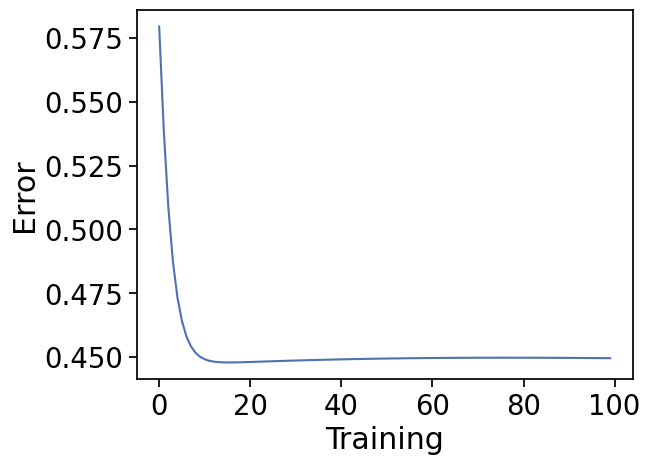

Training Accuracy 55.04%


In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the accuracy chart
accuracy = (1 - error) * 100

plt.plot(errors)
plt.xlabel('Training')
plt.ylabel('Error')
plt.show()

print("Training Accuracy " + str(round(accuracy,2)) + "%")

# Evaluating the model

<font color='blue'>Cell 18
Running the evaluation function

In [39]:
y_pred = evaluation(trained_params,X_train)

<font color='blue'>Cell 19
Making the confusion matrix

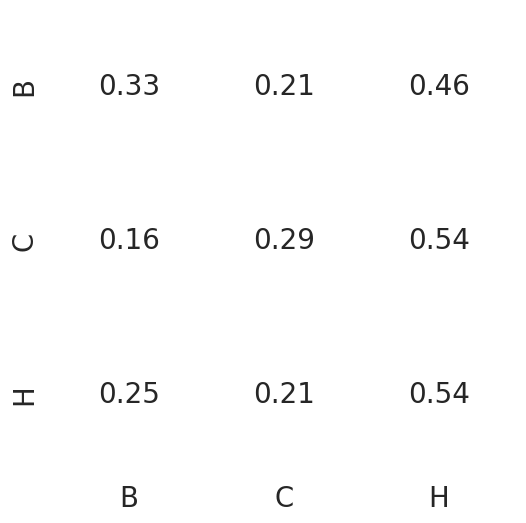

In [40]:
y_actual = pd.Series(y_train.argmax(axis=1))
y_pred = pd.Series(y_pred.argmax(axis=1))
cm = pd.crosstab(y_actual,y_pred).to_numpy()
if cm.shape[1] == 2 :
    cm = np.insert(cm, 2, [0,0,0], axis=1)
cm_norm = np.array([cm[i][j]/cm[i].sum() for i in range(cm.shape[0]) for j in range(cm.shape[1])])
cm_norm = cm_norm.reshape(3,3)

import seaborn as sns
from matplotlib.colors import ListedColormap


#To use the seaborn heatmap, the confusion matrix array "cm" must be placed into a dataframe
#index specifies the row labels as B, C, H
#columns specifies the column labels as B, C, H
df_cm = pd.DataFrame(cm_norm, index = [i for i in "BCH"],
                  columns = [i for i in "BCH"])


#Setting figure size
plt.figure(figsize = (6,6))

with sns.axes_style('white'):
    sns.heatmap(df_cm,
                cbar=False,
                square=False,
                annot=True,
                annot_kws={"size": 20},
                cmap=ListedColormap(['white']),
                linewidths=0.5)
    sns.set(font_scale=1.8)

# Exercise 4.2

<font color='blue'>Cell 20
Running the sequence prediction function

In [41]:
tested_seq_filename = '/content/sequence2.txt'
sequence_prediction(tested_seq_filename)

Amino Acid Sequence  :  KMSEKLRIKVDDVKINPKYVLYGVSTPNKRLYKRYSEFWKLKTRLERDVGSTIPYDFPEKPGVLDRRWQRRYDDPEMIDERRIGLERFLNELYNDRFDSRWRDTKIAQDFLQLSKPN
Predicted Structure  :  CHHCHHBBBHBCCBBBHCHHHHBCHHCHHHCBHHHHHHHCHBBBHHCBCHHBCCBHHHHHHCCBHHCHHHCHBCCHHHCHCHHCHHCHHHHHHCHHHBHHCHHHBHBHHBHHBBHHB
